In [1]:
## Scaffold for Michelangelo customers 
## authors: will.zou@uber.com dmantar@uber.com 
## Causal Models for real-time incentives 
## import libraries and modules 

import sys, os, pandas as pd, numpy as np, pickle as pkl, tensorflow as tf 
sys.path.append('../dataprep/') 
from QueryFunctions import * 


In [2]:
### pull data either using queryrunner or using csv 
use_query = 0 ### turn this switch on (to 1.0/True vs 0.0/False) to run query using QueryRunner 
use_python3 = True 

if use_query: 
    from queryrunner_client import Client 
    qr = Client(user_email='will.zou@uber.com') 
    ##label_dates_weekly = "'2019-07-14', '2019-07-21', '2019-07-28', '2019-08-04'" 
    ##city_ids = '1,5,6,8,10,12,20,23,198' 
    #feature_dates="'2019-06-30'" 
    #proposal_start_date = '2019-07-08' 
    
    predFrame2 = qr.execute('presto', rt_data_presto_first()) 
    predFrame2 = pd.DataFrame(predFrame2.load_data()) 
else: 
    predFrame2 = pd.read_csv('../data/rt_query_result_rider.csv') 


In [3]:
### Cross check on treatment and control cohort sizes 
cohort_column_name = 'treatment' 
treatment_indicator_value = True 
control_indicator_value = False 
print('size of dataset:') 
print(len(predFrame2)) 
print('size of control cohort:') 
print(sum(predFrame2[cohort_column_name] == control_indicator_value)) 
print('size of treatment cohort:') 
print(sum(predFrame2[cohort_column_name] == treatment_indicator_value)) 


size of dataset:
152417
size of control cohort:
124645
size of treatment cohort:
27772


In [4]:
### we should process the data such that route level cost and gains are per-session 
### so it's possible to rank the routes separately and it should be able to compare with results for 
### using rider information only 

### three data tables: 
### 1. with rider + route features and per route metrics 
### 2. with rider features and per rider metrics 
### 3. with route features and per route metrics 

### for table 1, we can have two algorithms 
### a. train a model on Table 2, score the riders as a feature for route-level model, then use route level model to evaluate 
### b. train a combined model on table 1 


In [5]:
### preprocess the data 
### -- sample treatment to match control cohort 
### -- eliminate nulls, standard normalization 

D = predFrame2 
D = D.sample(frac=1.0) 

"""
feature_list = [ 
    'rating_2driver_min_avg_84d'
    , 'trip_incomplete_total_84d'
    , 'days_active_84d'
    , 'days_since_trip_first_lifetime'
    , 'days_since_last_hard_churn_lifetime'
    , 'days_since_last_soft_churn_lifetime'
    , 'fare_max_sd_84d'
    , 'churns_hard_lifetime'
    , 'trips_lifetime'
    , 'fare_max_p50_84d'
    , 'duration_session_pre_request_max_p50_84d'
    , 'trip_pool_per_x_84d'
    , 'fare_total_win7d_sd_84d'
    , 'trip_complete_win7d_sd_84d'
    , 'session_per_days_active_84d'
    , 'churns_soft_lifetime'
    , 'trip_complete_per_days_active_84d'
    , 'trip_pool_prc_84d'
    , 'session_background_pre_request_prc_84d'
    , 'session_lt_1m_prc_84d'
    , 'session_request_prc_84d'
    , 'duration_session_outside_total_prc_84d'
    , 'trip_x_prc_84d'
    , 'days_since_trip_last_lifetime'
    , 'promo_used_84d'
    , 'has_session_request_84d'
    , 'has_session_without_request_84d' 
    , 'fare_promo_total_avg_84d', 
    'fare_total_avg_84d', 
    'surge_trip_avg_84d', 
    'fare_total_win7d_potential_84d', 
    'fare_total_win28d_potential_84d', 
    'fare_lifetime', 
    'time_to_first_message_minutes_mean_lifetime', 
    'ata_trip_max_avg_84d', 
    'eta_trip_max_avg_84d', 
    'trip_pool_matched_avg_84d', 
    'payment_cash_trip_total_84d', 
    'duration_trip_total_p50_84d'
] 
"""
feature_list = [ 
    'rating_2driver_min_avg_84d'
    , 'days_active_84d'
    , 'days_since_trip_first_lifetime'
    , 'days_since_last_soft_churn_lifetime'
    , 'churns_hard_lifetime'
    , 'fare_max_p50_84d'
    , 'fare_total_win7d_sd_84d'
    , 'trip_complete_win7d_sd_84d'
    , 'trip_pool_prc_84d'
    , 'session_request_prc_84d'
    , 'days_since_trip_last_lifetime'
    , 'fare_promo_total_avg_84d'
    , 'fare_total_avg_84d'
    , 'surge_trip_avg_84d'
    , 'fare_total_win28d_potential_84d'
    , 'ata_trip_max_avg_84d'
    , 'duration_trip_total_p50_84d'
    , 'promo_used_84d'
#    , 'estimate_fare_distance_in_miles' 
#    , 'estimate_fare_duration_in_minutes' 
#    , 'origin_destination_haversine_miles' 
#    , 'origin_lat' 
#    , 'origin_lng'
#    , 'destination_lat'
#    , 'destination_lng'  
] 

label_list = [ 
    'gross_bookings_usd', 
    'variable_contribution_usd', 
    'num_sessions' 
] 

for l in feature_list: 
    print('number of nans: ' + str(sum(D[l] == '\\N'))) 
    D[l] = pd.to_numeric(D[l], errors='coerce') 
    D[l] = D[l] - D[l].mean() 
    D[l] = D[l] / D[l].std() 
    D[l][pd.isnull(D[l])] = 0.0 ## at zero mean due to standard normalization 

for l in label_list: 
    D[l] = pd.to_numeric(D[l], errors='coerce') 
    D[l][pd.isnull(D[l])] = 0.0 ## for zero gain/cost for financial data 

### -- compute simple statistics 
### compute cpit 
treated_entries = D[D[cohort_column_name] == treatment_indicator_value] 
untreated_entries = D[D[cohort_column_name] == control_indicator_value] 

rpu_treated = float(treated_entries[label_list[0]].sum()) / len(treated_entries) 
nipu_treated = float(treated_entries[label_list[1]].sum()) / len(treated_entries) 

rpu_untreated = float(untreated_entries[label_list[0]].sum()) / len(untreated_entries) 
nipu_untreated = float(untreated_entries[label_list[1]].sum()) / len(untreated_entries) 

cpit = -1.0 * (nipu_treated - nipu_untreated) / (rpu_treated - rpu_untreated) 

print('rpu_treated : ' + str(rpu_treated)) 
print('nipu_treated : ' + str(nipu_treated)) 
print('rpu_untreated : ' + str(rpu_untreated)) 
print('nipu_untreated : ' + str(nipu_untreated)) 
print('cpit : ' + str(cpit)) 

### split the data into 3/1/1 train/val/test 
len_tr = int(len(D) / 5 * 3) 
len_va = int(len(D) / 10 * 1) 

nX = D[feature_list].values 
w = D[cohort_column_name].apply(lambda x: 1.0 if x == treatment_indicator_value else 0.0) 
w = w.values 
values = D[label_list[0]] 
values = values.values * 1.0 
negcost = D[label_list[1]] 
negcost = negcost.values * 1.0 
num_sessions = D[label_list[2]].values 
#values = np.divide(values, num_sessions) 
#negcost = np.divide(negcost, num_sessions) 

## split train/val/test sets 

nX_tr = nX[0:len_tr, :] 
nX_va = nX[len_tr:len_tr + len_va, :] 
nX_te = nX[len_tr + len_va:, :] 

w_tr = w[0:len_tr]
w_va = w[len_tr:len_tr + len_va] 
w_te = w[len_tr + len_va:] 

values_tr = values[0:len_tr] 
values_va = values[len_tr:len_tr + len_va] 
values_te = values[len_tr + len_va:] 

negcost_tr = negcost[0:len_tr] 

negcost_va = negcost[len_tr:len_tr + len_va] 

negcost_te = negcost[len_tr + len_va:] 

## saving data using cPickel and naming the dictionaries 
saveD = {'nX_tr':nX_tr, 
         'w_tr':w_tr, 
         'values_tr':values_tr, 
         'nX_va':nX_va, 
         'w_va':w_va, 
         'values_va':values_va, 
         'nX_te':nX_te, 
         'w_te':w_te, 
         'values_te':values_te, 
         'feature_list':feature_list, 
         #'avg_ni_usd_tr':avg_ni_usd_tr, 
         'negcost_tr': negcost_tr, 
         #'avg_ni_usd_va':avg_ni_usd_va, 
         'negcost_va': negcost_va, 
         #'avg_ni_usd_te':avg_ni_usd_te, 
         'negcost_te': negcost_te 
         } 

pkl.dump(saveD, open('../data/rt_ma_training_data_v5_2019_07_08_vc_tr_featuremod3_rider', 'wb')) 


number of nans: 28779
number of nans: 3011


/Users/will.zou/code/deeplearning_hscls/py3/lib/python3.6/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


number of nans: 3011
number of nans: 3016
number of nans: 3016
number of nans: 3011
number of nans: 3011
number of nans: 3011
number of nans: 4123
number of nans: 4123
number of nans: 3011
number of nans: 100966
number of nans: 3011
number of nans: 3011
number of nans: 3025
number of nans: 3089
number of nans: 3011
number of nans: 4123


/Users/will.zou/code/deeplearning_hscls/py3/lib/python3.6/site-packages/ipykernel_launcher.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


rpu_treated : 67.8501334702578
nipu_treated : -4.760137201665052
rpu_untreated : 58.15015138020138
nipu_untreated : 6.383521133572327
cpit : 1.1488328773989065


In [6]:
sum(num_sessions)
print('total gross bookings: ' + str(sum(values)))
print('total variable contribution: ' + str(sum(negcost)))

total gross bookings: 9132459.525520967
total variable contribution: 663475.4613294642


In [7]:
"""
D=predFrame2
D[D['rider_uuid']=='b57c08f5-edfd-441c-ad2d-08ecda3391fb']
"""

"\nD=predFrame2\nD[D['rider_uuid']=='b57c08f5-edfd-441c-ad2d-08ecda3391fb']\n"

In [8]:
sum(negcost == 0)


24428

load data from ../data/rt_ma_training_data_v5_2019_07_08_vc_tr_featuremod3_rider
printing averages of c_tr, c_unt, o_tre, o_unt ... :
4.030008179960382
-6.293439949881827
68.08112415559155
58.4632452017676
### ----- start the training of deep learning models ------ 
------> Training TQR ranking model .... 
---> running cross validation, iteration: 0



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `layer.__call__` method instead.


opt. step : 0 obj: 1.1172842481901468
setting temperature to :0.6
opt. step : 100 obj: 1.071792302798357
setting temperature to :0.7
opt. step : 200 obj: 1.010369510145437
setting temperature to :0.7999999999

---------------------------->>>>>>
perc - target: 0.30
treated_target_rpu: 69.77
treated_target_nipu: -2.70
nontreated_target_rpu: 58.50
nontreated_target_nipu: 6.68
treated_nontarget_rpu: 65.87
treated_nontarget_nipu: -4.89
nontreated_nontarget_rpu: 57.13
nontreated_nontarget_nipu: 6.27
--- with 29.99606350872589% targeting, print cpits to treat users and create incrementality in users ---
--> in targeted users: 
cpit = 0.8327594728355239
--> in non-targeted users: 
cpit = 1.2772081183666502
rpu_control: 57.54
nipu_control: 6.40
rpu_ft: 67.05
nipu_ft: -4.22
rpu_cohort: 60.92
nipu_cohort: 3.58
lift targeted cohort vs control: 0.06
lift random vs control: 0.17
cpit cohort vs control: 0.83
lift targeted-treated vs control: 0.21
cpit cohort: 0.832422
---------------------------->>>>>>
perc - target: 0.40
treated_target_rpu: 69.83
treated_target_nipu: -2.58
nontreated_target_rpu: 58.83
nontreated_target_nipu: 6.87
treated_nontarget_rpu: 65.16
treated_nontarget_nipu: -5.34
nontreated_nontar

../experimentation.py:109: RuntimeWarning: invalid value encountered in long_scalars
  treated_untarget_rpu = sum(1.0 * values[treated_untargeted_filter]) / sum(treated_untargeted_filter)
../experimentation.py:110: RuntimeWarning: invalid value encountered in long_scalars
  treated_untarget_nipu = sum(1.0 * n9d_ni_usd[treated_untargeted_filter]) / sum(treated_untargeted_filter)


rpu_cohort
66.26241439614891
treated_target_rpu
67.05182163537394
---------------------------->>>>>>
perc - target: 1.00
treated_target_rpu: 67.05
treated_target_nipu: -4.22
nontreated_target_rpu: 57.55
nontreated_target_nipu: 6.40
treated_nontarget_rpu: nan
treated_nontarget_nipu: nan
nontreated_nontarget_rpu: 23.44
nontreated_nontarget_nipu: 2.23
--- with 99.98687836241963% targeting, print cpits to treat users and create incrementality in users ---
--> in targeted users: 
cpit = 1.1172720209140743
--> in non-targeted users: 
cpit = nan
rpu_control: 57.54
nipu_control: 6.40
rpu_ft: 67.05
nipu_ft: -4.22
rpu_cohort: 67.05
nipu_cohort: -4.22
lift targeted cohort vs control: 0.17
lift random vs control: 0.17
cpit cohort vs control: 1.12
lift targeted-treated vs control: 0.17
cpit cohort: 1.116560
rpu_control: 57.541300766652434
nipu_control: 6.395390112802487
rpu_ft: 67.05182163537381
nipu_ft: -4.223677512349505
---------------------------->>>>>>
perc - target: 0.10
treated_target_rpu: 1

---------------------------->>>>>>
perc - target: 0.10
treated_target_rpu: 143.53
treated_target_nipu: -10.08
nontreated_target_rpu: 106.64
nontreated_target_nipu: 6.88
treated_nontarget_rpu: 58.81
treated_nontarget_nipu: -3.59
nontreated_nontarget_rpu: 52.05
nontreated_nontarget_nipu: 6.34
--- with 9.998687836241963% targeting, print cpits to treat users and create incrementality in users ---
--> in targeted users: 
cpit = 0.4595705721094528
--> in non-targeted users: 
cpit = 1.4694192252856568
rpu_control: 57.54
nipu_control: 6.40
rpu_ft: 67.05
nipu_ft: -4.22
rpu_cohort: 61.20
nipu_cohort: 4.70
lift targeted cohort vs control: 0.06
lift random vs control: 0.17
cpit cohort vs control: 0.46
lift targeted-treated vs control: 1.49
cpit cohort: 0.463778
---------------------------->>>>>>
perc - target: 0.20
treated_target_rpu: 114.19
treated_target_nipu: -7.43
nontreated_target_rpu: 89.74
nontreated_target_nipu: 7.23
treated_nontarget_rpu: 55.37
treated_nontarget_nipu: -3.43
nontreated_no

---------------------------->>>>>>
perc - target: 0.20
treated_target_rpu: 54.17
treated_target_nipu: -3.56
nontreated_target_rpu: 37.92
nontreated_target_nipu: 1.16
treated_nontarget_rpu: 70.31
treated_nontarget_nipu: -4.39
nontreated_nontarget_rpu: 62.43
nontreated_nontarget_nipu: 7.70
--- with 19.997375672483926% targeting, print cpits to treat users and create incrementality in users ---
--> in targeted users: 
cpit = 0.2902529519206703
--> in non-targeted users: 
cpit = 1.5342994533638987
rpu_control: 57.54
nipu_control: 6.40
rpu_ft: 67.05
nipu_ft: -4.22
rpu_cohort: 60.78
nipu_cohort: 5.45
lift targeted cohort vs control: 0.06
lift random vs control: 0.17
cpit cohort vs control: 0.29
lift targeted-treated vs control: -0.06
cpit cohort: 0.292169
---------------------------->>>>>>
perc - target: 0.30
treated_target_rpu: 54.06
treated_target_nipu: -3.12
nontreated_target_rpu: 40.59
nontreated_target_nipu: 2.40
treated_nontarget_rpu: 72.82
treated_nontarget_nipu: -4.71
nontreated_nont

---------------------------->>>>>>
perc - target: 0.30
treated_target_rpu: 62.50
treated_target_nipu: -3.95
nontreated_target_rpu: 46.50
nontreated_target_nipu: 2.82
treated_nontarget_rpu: 69.08
treated_nontarget_nipu: -4.35
nontreated_nontarget_rpu: 62.23
nontreated_nontarget_nipu: 7.92
--- with 29.99606350872589% targeting, print cpits to treat users and create incrementality in users ---
--> in targeted users: 
cpit = 0.42280926685353565
--> in non-targeted users: 
cpit = 1.7894274944395252
rpu_control: 57.54
nipu_control: 6.40
rpu_ft: 67.05
nipu_ft: -4.22
rpu_cohort: 62.31
nipu_cohort: 4.36
lift targeted cohort vs control: 0.08
lift random vs control: 0.17
cpit cohort vs control: 0.43
lift targeted-treated vs control: 0.09
cpit cohort: 0.427448
---------------------------->>>>>>
perc - target: 0.40
treated_target_rpu: 62.53
treated_target_nipu: -3.51
nontreated_target_rpu: 48.08
nontreated_target_nipu: 3.63
treated_nontarget_rpu: 70.17
treated_nontarget_nipu: -4.71
nontreated_nonta

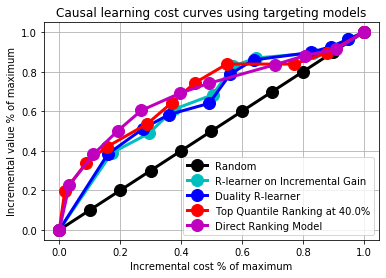

In [9]:
### code implements ranking model for treatment effect 
### for optimizing with respect to direct marketplace objectives 
### using tensorflow 

import numpy as np, tensorflow as tf, pandas as pd, pickle as pkl 
sys.path.append('../')  
from ModelDefinitions import * 
from DataProcFunctions import * 

### RxGy TQR setting: 
p_quantile = 0.4 ## percentage of quantile to aim for 
num_optimize_iterations = 2000 ## number of optimization iterations 
num_modeling_inits = 2 ## number of random initializations 
num_hidden = 0 ## number of hidden units in DNN 
use_schedule = True ## option to use a constraint annealing schedule 
temp = 0.5 ## initial temperature for constraints 
inc_temp = 0.1 ## increment of temperature per 100 iterations 
save_cf_data = False ### whether to save data for causal forest training 

## set a random seed to reproduce results 
seed = 1234; tf.compat.v2.random.set_seed(seed); np.random.seed(seed) 

sample_frac = 1.0 ## option to sample data by a fraction \in (0, 1) 
data_filename =  '../data/rt_ma_training_data_v5_2019_07_08_vc_tr_featuremod3_rider' 
prefix = 'rt_v5_07_08_featuremod3_tr_iter100_run4_rider' 

D_tre, D_unt, Dv_tre, Dv_unt, Dt_tre, Dt_unt, o_tre, o_unt, ov_tre, ov_unt, ot_tre, ot_unt, c_tre, c_unt, cv_tre, cv_unt, ct_tre, ct_unt, D, w, o, c, Dv, wv, ov, cv, Dt, wt, ot, ct = LoadDataFromPkl(data_filename, frac = sample_frac, use_python3=use_python3, save_cf_data=save_cf_data) 

print('### ----- start the training of deep learning models ------ ') 
gs_tqr = [] 
gs_drm = [] 
for i in range(num_modeling_inits): 
    gs_tqr.append(tf.Graph()) 
for i in range(num_modeling_inits): 
    gs_drm.append(tf.Graph()) 

print('------> Training TQR ranking model .... ') 
val_results = [] 
sess_list = [] 
for i in range(num_modeling_inits): 
    print('---> running cross validation, iteration: ' + str(i)) 
    obj, opt, dumh, dumhu, vtemp, p_quantile = TunableTQRankingModelDNN(gs_tqr[i], D_tre, D_unt, o_tre, o_unt, c_tre, c_unt, 'train-first', temp, p_quantile, num_hidden, use_schedule) 
    ### session definitions and variable initialization 
    sess = tf.Session(graph = gs_tqr[i]) 
    sess_list.append(sess) 
    
    ### initialize variables and run optimization 
    with gs_tqr[i].as_default() as g: 
        init = tf.global_variables_initializer() 
    sess.run(init) 
    cur_temp = temp 
    for step in range(num_optimize_iterations): 
        _, objres = sess.run([opt, obj]) 
        if step % 100 == 0: 
            cur_temp = cur_temp + inc_temp 
            print('opt. step : ' + str(step) + ' obj: ' + str(objres)) 
            if use_schedule: 
                sess.run(vtemp.assign(cur_temp))
                print('setting temperature to :' + str(sess.run(vtemp))) 
    
    print('---> optimization finished ... ') 
    tempvalue = sess.run(vtemp)
    p_quantilevalue = p_quantile
    print('temp:') 
    print(tempvalue)
    print('p_quantile:')
    print(p_quantilevalue) 
    
    ### evaluate CPIT metric on validation set 
    objv, dumo, dumh, dumhu, dvtemp, dp_quantile = TunableTQRankingModelDNN(gs_tqr[i], Dv_tre, Dv_unt, ov_tre, ov_unt, cv_tre, cv_unt, 'eval', temp, p_quantile, num_hidden, use_schedule) 
    
    val_result = sess.run(objv) 
    print('validation CPIT:') 
    print(val_result) 
    val_results.append(val_result) 

from operator import itemgetter 
best_index = min(enumerate(val_results), key=itemgetter(1))[0] 

print('best performing model: iteration ' + str(best_index)) 

### run scoring on whole test set 
with gs_tqr[best_index].as_default() as g: 
    if num_hidden > 0: 
        with tf.variable_scope("tqrhidden") as scope: 
            h1_test = tf.contrib.layers.fully_connected(Dt, num_hidden, activation_fn=tf.nn.tanh, reuse=tf.AUTO_REUSE, scope=scope, weights_initializer=tf.contrib.layers.xavier_initializer()) 
        with tf.variable_scope("tqranker") as scope: 
            h_test = tf.contrib.layers.fully_connected(h1_test, 1, activation_fn=None, reuse=tf.AUTO_REUSE, scope=scope) 
    else: 
        with tf.variable_scope("tqranker") as scope: 
            h_test = tf.contrib.layers.fully_connected(Dt, 1, activation_fn=None, reuse=tf.AUTO_REUSE, scope=scope) 
    tqrscore = sess_list[best_index].run(h_test) 

print('------> Training DRM ranking model .... ') 
sess_list = [] 
val_results = [] 
for i in range(num_modeling_inits): 
    print('---> running cross validation, iteration: ' + str(i)) 
    ### ---- train cpit ranking model for comparison --- 
    dobjc, doptc, ddumh, ddumu = DirectRankingModelDNN(gs_drm[i], D_tre, D_unt, o_tre, o_unt, c_tre, c_unt, 'train-first-drm', num_hidden) 
    
    dsess = tf.Session(graph = gs_drm[i]) 
    sess_list.append(dsess) 
    
    ### initialize variables and run optimization 
    with gs_drm[i].as_default() as g: 
        dinit = tf.global_variables_initializer() 
    dsess.run(dinit) 
    for step in range(num_optimize_iterations): 
        _, dobjres = dsess.run([doptc, dobjc]) 
        if step % 100 == 0: 
            print('opt. step : ' + str(step) + ' obj: ' + str(dobjres)) 
    
    print('---> optimization finished ... ') 
    
    ### evaluate CPIT metric on validation set 
    dobjv, ddumo, dumh, dumhu = DirectRankingModelDNN(gs_drm[i], Dv_tre, Dv_unt, ov_tre, ov_unt, cv_tre, cv_unt, 'eval', num_hidden)
    val_result = dsess.run(dobjv) 
    print('validation CPIT:') 
    print(val_result) 
    val_results.append(val_result) 

best_index = min(enumerate(val_results), key=itemgetter(1))[0] 

print('best performing model: iteration ' + str(best_index)) 

### run scoring on whole test set 
with gs_drm[best_index].as_default() as g: 
    if num_hidden > 0: 
        with tf.variable_scope("drmhidden") as scope: 
            h1_test = tf.contrib.layers.fully_connected(Dt, num_hidden, activation_fn=tf.nn.tanh, reuse=tf.AUTO_REUSE, scope=scope, weights_initializer=tf.contrib.layers.xavier_initializer()) 
        with tf.variable_scope("drmranker") as scope: 
            h_test = tf.contrib.layers.fully_connected(h1_test, 1, activation_fn=tf.nn.tanh, reuse=tf.AUTO_REUSE, scope=scope) 
    else: 
        with tf.variable_scope("drmranker") as scope: 
            h_test = tf.contrib.layers.fully_connected(Dt, 1, activation_fn=tf.nn.tanh, reuse=tf.AUTO_REUSE, scope=scope) 
    drmscore = sess_list[best_index].run(h_test) 

### ---- train hte model for comparison ---- 
### we could utimize the original HTE functions 
from LinearHTEModels import * 
from PromotionModels import PromotionModels 

pmodels = PromotionModels() 

## set-up RLearner 
rl_ridge_model_O, rl_ridge_model_C = pmodels.fit_rlearner(D, o, c, w) 

## one model for order lift and one model for cost drop 
pred_values_va_rlearner_O = rl_ridge_model_O.predict(Dt) 
pred_values_va_rlearner_C = rl_ridge_model_C.predict(Dt) 

#plt.imagesc(np.concatneate(rl_ridge_model_O.params, ...params), axis=1) 

#if ranking_model == 'effectiveness-ratio': ## if we use the effectiveness ratio model, compute effectiveness ratio 
pred_values_va_rlearner = np.divide(np.maximum(pred_values_va_rlearner_O, 0), pred_values_va_rlearner_C + 1e-7) 

lhmodels = LinearHTEModels() 
lambds = [0.1] 
rlearnerscores = [] 
rl_ridge_model_L_list = [] 
## set-up lagrangian rlearner 
for i in range(len(lambds)): 
    lambd = lambds[i] 
    rl_ridge_model_L = lhmodels.fit_rlearner_lagrangian(D, o, c, w, lambd) 
    rl_ridge_model_L_list.append(rl_ridge_model_L) 
    rlearnerscores.append(rl_ridge_model_L.predict(Dt)) 

""" 
### this section is to load the results trained by grf R code 
### 

ot_cf = pd.read_csv('../results/causal_forest_grf_test_set_results_O_finalsize_numtrees1002.csv') 
ct_cf = pd.read_csv('../results/causal_forest_grf_test_set_results_C_finalsize_numtrees1002.csv') 

ot_cf = ot_cf.values() 
Ocfscores = ot_cf[0] 

ct_cf = ct_cf.values() 
Ccfscores = ct_cf[0] 

cfscore = np.divide(Ocfscores, Ccfscores) 
""" 

### ---- experimentation and plotting cost-curves ----- 
from experimentation import * 
exp = Experimentation() 
ranscore = np.random.rand(ot.shape[0], ) 
colors = ['b', 'c', 'g', 'y'] 
plt.figure() 
rlearnerauccs = [] 
ranaucc = exp.AUC_cpit_cost_curve_deciles_cohort(ranscore, ot, wt, -1.0 * ct, 'k', plot_random=True) 
quasiaucc = exp.AUC_cpit_cost_curve_deciles_cohort(pred_values_va_rlearner_O, ot, wt, -1.0 * ct, 'c') 
for i in range(len(lambds)): 
    rlearnerauccs.append(exp.AUC_cpit_cost_curve_deciles_cohort(rlearnerscores[i], ot, wt, -1.0 * ct, colors[i] )) 
#cfaucc = exp.AUC_cpit_cost_curve_deciles_cohort(cfscore, ot, wt, -1.0 * ct, 'g') # causal forest aucc and plotting 
tqraucc = exp.AUC_cpit_cost_curve_deciles_cohort(tqrscore, ot, wt, -1.0 * ct, 'r' ) 
drmaucc = exp.AUC_cpit_cost_curve_deciles_cohort(drmscore, ot, wt, -1.0 * ct, 'm' ) 
plt.title('Causal learning cost curves using targeting models') 

print('temp:') 
print(tempvalue) 
print('p_quantile:') 
print(p_quantilevalue) 

### --- add legeneds to plot ---- 
leg_str = ['Random'] 
leg_str.append('R-learner on Incremental Gain') 
for i in range(len(lambds)): 
    leg_str.append('Duality R-learner') 
#leg_str.append('Causal Forest') # causal forest result 
leg_str.append('Top Quantile Ranking at ' + str(p_quantile*100) + '%') 
leg_str.append('Direct Ranking Model') 
plt.legend(leg_str) 

### --- print out aucc results for different models --- 
print('AUCC results: ') 
print('random: ' + str(ranaucc)) 
print('rlearner: ' + str(quasiaucc)) 
i = 0
for rlearneraucc in rlearnerauccs: 
    print('duality rlearner ' + str(i + 1) + ' with lambda = ' + str(lambds[i]) + ':' + str(rlearneraucc)) 
    i = i + 1
print('drm: ' + str(drmaucc)) 
print('tqr: ' + str(tqraucc)) 

plt.show() 

### --- saving data to results folder ---- 
save_filename = '../results/benchmarkwithcv_tqr_drm_hte_'+prefix+'_main_results.pkl' 
saveD = {'tqrscore':tqrscore, 'drmscore':drmscore, 'quasiscore':pred_values_va_rlearner, 'quasiscore_O':pred_values_va_rlearner_O, 'rlearnerscore':rlearnerscores, 'ot':ot, 'wt':wt, 'ct':ct, 'tempvalue':tempvalue, 'p_quantilevalue':p_quantilevalue, 
         'tqraucc':tqraucc, 'drmaucc':drmaucc, 'rlearnerauccs':rlearnerauccs, 'ranaucc':ranaucc, 'quasiaucc':quasiaucc} 
#'cfscore':cfscore, causal forest scores 
pkl.dump(saveD, open(save_filename, 'wb')) 
